Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 68.9MB/s]


COntent shape =>  torch.Size([3, 300, 532])


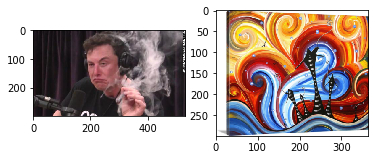

device =  cuda
epoch  10   tensor(8.6113e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  20   tensor(5.8512e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  30   tensor(5.2366e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  40   tensor(4.7983e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  50   tensor(4.4889e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  60   tensor(4.2329e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  70   tensor(3.9929e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  80   tensor(3.7537e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  90   tensor(3.5134e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  100   tensor(3.2785e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  110   tensor(3.0592e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  120   tensor(2.8655e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  130   tensor(2.7028e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  140   tensor(2.5710e+18, device='cuda:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.5528e+18, device='cuda:0', grad_fn=<AddBackward0>)


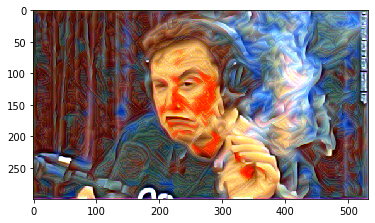

ValueError: ignored

In [1]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

device = ("cuda" if torch.cuda.is_available() else "cpu")


model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)

def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features





transform = transforms.Compose([transforms.Resize(300),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


content = Image.open("content.jpg").convert("RGB")
content = transform(content).to(device)
print("COntent shape => ", content.shape)
style = Image.open("style.jpg").convert("RGB")
style = transform(style).to(device)

def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return x

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content),label = "Content")
ax2.imshow(imcnvt(style),label = "Style")
plt.show()

def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    
    return gram_mat


target = content.clone().requires_grad_(True).to(device)

#set device to cuda if available
print("device = ",device)


style_features = model_activations(style,model)
content_features = model_activations(content,model)

style_wt_meas = {"conv1_1" : 1.0, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

content_wt = 100
style_wt = 1e8

print_after = 500
epochs = 4000
optimizer = torch.optim.Adam([target],lr=0.007)

for i in range(1,epochs+1):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
    
    total_loss = content_wt*content_loss + style_wt*style_loss 
    
    if i%10==0:       
        print("epoch ",i," ", total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_after == 0:
        plt.imshow(imcnvt(target),label="Epoch "+str(i))
        plt.show()
        plt.imsave(str(i)+'.png',imcnvt(target),format='png')





